<a href="https://colab.research.google.com/github/liuxx479/kappaTNG/blob/master/kappaTNG_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import numpy as np
from pylab import *
import os
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy.special import factorial
from matplotlib.gridspec import GridSpec
from scipy.interpolate import splev, splrep
%matplotlib inline

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
root = '/content/drive/My Drive/kappaTNG/'
zs = np.genfromtxt(root+'Clkk_ratio/zs.dat')

In [132]:
# print (zs)
zs_target = zs#[0.506387, 1.034093, 1.532007, 2.093596]
zs_string = ''
for izs in zs_target: zs_string+=str(izs)+','
zs_string=zs_string[:-1]
# print (zs_string)

In [133]:
######## parameters

# LCDM parameters
A_s = 2.142e-9
h=0.6774
OmegaB = 0.0486
OmegaM = 0.3089
n_s = 0.9667


### derived parameters
#z_reio = 10.0 #11.357
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100
### accuracy parameters
lmax=10000

In [6]:
######## install class if need
# !git clone https://github.com/lesgourg/class_public.git class
# os.chdir('class')
# !make
# https://github.com/lesgourg/class_public/blob/master/explanatory.ini

In [7]:
# from classy import Class

In [8]:
# LambdaCDM = Class()
# LambdaCDM.set({'omega_b':ombh2,'omega_cdm':omch2,'h':h,'A_s':A_s,'n_s':n_s})
# LambdaCDM.set({'output':'mPk,sCl',
#                 'P_k_max_1/Mpc':5.0,
#                 #'z_pk':0,
#                 #'reio_parametrization':'reio_none',
#                 # 'l_switch_limber':100,
#                 'selection':'dirac',
#                 'selection_mean': zs_string, #selection_mean = 0.98,0.99,1.0,1.1,1.2
#                 'l_max_lss':lmax,
#                'non linear':'halofit'
#                 # 'non linear':'HMcode'
#               })


In [9]:
# LambdaCDM.compute()

# si8=LambdaCDM.sigma8()

# cls=LambdaCDM.density_cl(lmax)

# ell=cls['ell'][2:]
# clphiphi=cls['ll'][0][2:]
# clkk=1.0/4 * (ell+2.0)*(ell+1.0)*(ell)*(ell-1.0)*clphiphi


In [10]:
# cls.keys()
# # cls['ll']
# save(root+'takahashi_ell.npy', cls['ell'])
# save(root+'takahashi_cls.npy', cls['ll'])

In [134]:
# !pip install camb

In [12]:
# import camb
# from camb import model, initialpower
# print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

# #Set up a new set of parameters for CAMB
# pars = camb.CAMBparams()
# #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
# pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, omk=0, 
#                    tau=0, mnu=0, neutrino_hierarchy='normal')


# pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
# pars.set_matter_power(redshifts=[0.,], kmax=10.0)
# pars.set_for_lmax(lmax, lens_potential_accuracy=0);

# pars.SourceWindows = [camb.sources.GaussianSourceWindow(redshift=izs, source_type='lensing', sigma=0.0001) for izs in zs]

# #calculate results for these parameters
# results = camb.get_results(pars)
# # powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
# # for name in powers: print(name)

# ## Clkk
# cls_Wz = results.get_source_cls_dict()
# for name in cls_Wz: print(name)
# clkk_camb = cls_Wz['W1xW1'][2:]
# ls2=  np.arange(2, len(clkk_camb)+2)
# #print type(clkk_camb),type(ls2)

In [135]:
############# fitting formula from Ken
zs2,  ls1,  ls2,  a1,  a2 = np.genfromtxt(root+'fitted_params_osato.txt', usecols=range(1,6)).T
ratio_osato_fun = lambda i: (1+(ell/ls1[i])**a1[i]) / (1+(ell/ls2[i])**a2[i])

[ 101.8234  144.      160.9969  218.7537  284.3995  359.3011  446.1363
  562.7012  713.0505  892.3582 1056.544  1192.623  1335.852  1497.288
 1681.971  1888.175  2119.545  2377.31   2668.762  2993.712  3359.343 ]


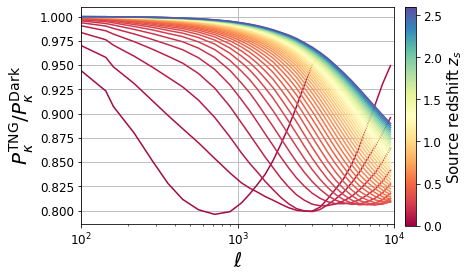

In [136]:
######### plot_ratio_all.py
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from IPython.display import Math, HTML

# plt.rc("text", usetex=True)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)


zs = np.loadtxt(root+"zs.dat")

fig = plt.figure(figsize=(6,4))
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)


for i in range(1, 41):
    d = np.loadtxt(root+"data/output/spec/ratio{:02d}.dat".format(i))
    if i == 1:
        ell = d[:21, 0]
        ratio = d[:21, 1]
        print(ell)
    else:
        ell = d[:, 0]
        ratio = d[:, 1]
    plt.plot(ell, ratio, c=cmap(norm(zs[i-1])))

plt.xscale('log')
plt.xlim(1e2, 1e4)
plt.xlabel(r'$\ell$', fontsize=20)
# plt.ylabel(r'$R (\ell)$', fontsize=15)
plt.ylabel(r'$P_\kappa^{\rm TNG}/P_\kappa^{\rm Dark}$', fontsize=20)

plt.grid()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.tight_layout()
# plt.savefig(root+"figures/ratio_all.pdf", bbox_inches='tight')
plt.show()


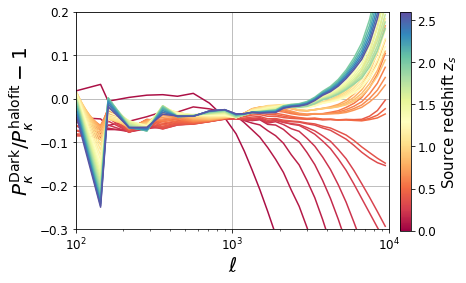

In [150]:
######### halofit comparison
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from IPython.display import Math, HTML
from scipy.interpolate import interp1d

fig = plt.figure(figsize=(6,4))
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)


for i in range(2, 41):
    # d = np.loadtxt(root+"output/spec/power{:02d}.dat".format(i))
    # ell = d[:, 0]
    # prefac = ell*(ell+1.0)/(2.0*np.pi)
    # Dlk = prefac*d[:, 6]
    # # ax0.plot(ell, Dlk, c=cmap(norm(zs[i-1])))

    d = np.loadtxt(root+"data/output_dark/spec/power{:02d}.dat".format(i))
    ell = d[:, 0]
    prefac = ell*(ell+1.0)/(2.0*np.pi)
    Dlk_Dark = prefac*d[:, 6]
    # ax0.plot(ell, Dlk_Dark, ls="--", c=cmap(norm(zs[i-1])))

    d = np.loadtxt(root+"data/output_theory/TNG_halofit_{}_cl.dat".format(i))
    # d = np.loadtxt(root+"data/output_theory/TNG_HMcode_emu_{}_cl.dat".format(i))
    # d = np.loadtxt(root+"data/output_theory/TNG_HMcode_dmonly_{}_cl.dat".format(i))
    ell_theory = d[:, 0]
    sCl = d[:, 1]
    Dlk_theory = 1.0/4.0*(ell_theory*(ell_theory+1.0))**2*sCl
    Dlk_theory_interp = interp1d(ell_theory, Dlk_theory)(ell)
    plt.plot(ell, Dlk_Dark/Dlk_theory_interp-1, ls='-', c=cmap(norm(zs[i-1])))

    # spl = splrep(ell_theory, Dlk_theory)
    # plt.plot(ell, Dlk_Dark/splev(ell, spl), ls='-', c=cmap(norm(zs[i-1])))

plt.xscale('log')
plt.xlim(1e2, 1e4)
plt.ylim(-0.3, 0.2)
plt.xlabel(r'$\ell$', fontsize=20)
# plt.ylabel(r'$R (\ell)$', fontsize=15)
plt.ylabel(r'$P_\kappa^{\rm Dark}/P_\kappa^{\rm halofit}-1$', fontsize=20)

plt.grid()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.tight_layout()
plt.savefig(root+"figures/power_halofit.pdf", bbox_inches='tight')
# plt.savefig(root+"figures/power_HMcode.pdf", bbox_inches='tight')
plt.show()


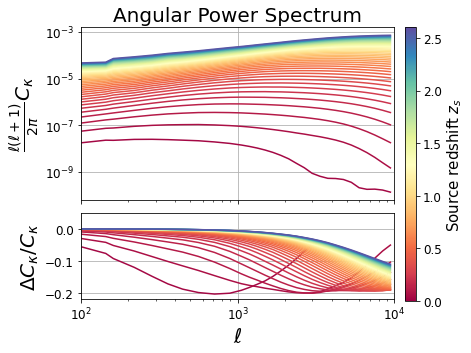

In [139]:
######### power spectrum

fig = plt.figure(figsize=(6,5))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)

for i in range(40):
  dps = np.loadtxt(root+"data/output/spec/power{:02d}.dat".format(i+1)).T
  dpsratio = np.loadtxt(root+"data/output/spec/ratio{:02d}.dat".format(i+1)).T
  ell, ips, ipsratio = dps[0], dps[6], dpsratio[1]

  ax0.plot(ell, ips*ell*(1+ell)/2/pi, c=cmap(norm(zs[i])))
  if i==0:
    ax1.plot(ell[:21], ipsratio[:21]-1, c=cmap(norm(zs[i])))
  else:
    ax1.plot(ell, ipsratio-1, c=cmap(norm(zs[i])))


ax0.grid()
ax0.set_xlim(1e2, 1e4)
ax0.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi} C_\kappa$', fontsize=20)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xticklabels([])

ax1.set_xscale('log')
ax1.set_xlim(1e2, 1e4)
ax1.set_ylim(0.78-1, 1.05-1)
ax1.grid()
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$\Delta C_{\kappa}/C_{\kappa}$', fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

ax0.set_title(r'Angular Power Spectrum', fontsize=20)
plt.savefig(root+"figures/PS_all.pdf", bbox_inches='tight')
plt.show()

In [101]:
d = np.array([np.loadtxt(root+"data/output/peaks/sm_2arcmin/pm{:02d}.dat".format(i)) for i in range(1,41)])
d_diff = np.array([np.loadtxt(root+"data/output/peaks/sm_2arcmin/diff{:02d}.dat".format(i)) for i in range(1,41)])
#nu peaks std minima std PDF std kappa2 std
print (d.shape)

(40, 300, 9)


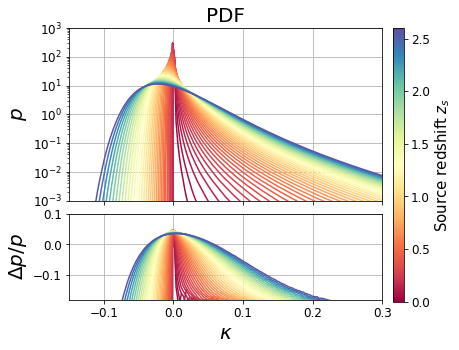

In [102]:
######### pdf
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from IPython.display import Math, HTML

fig = plt.figure(figsize=(6,5))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)

kappa = d[0,:,0]

for i in range(40):
  iy, iystd, iydiff = d[i, :, 5], d[i, :, 6], d_diff[i, :, 5]
  # kappastd = sqrt( sum(column1^2*column2*0.1*)/sum(column2*0.1) )
  idx=np.where(iy>1e-2)
  ax0.plot(kappa, iy, c=cmap(norm(zs[i])))
  ax1.plot(kappa[idx], iydiff[idx]/iy[idx], c=cmap(norm(zs[i])))


# ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(-0.15, 0.3)
ax0.set_ylim(1e-3, 1e3)
ax0.set_xticklabels([])
ax0.grid()
# ax0.set_xlabel(r'$\kappa$', fontsize=20)
ax0.set_ylabel(r'$p$', fontsize=20)


ax1.set_xlim(-0.15, 0.3)
ax1.set_ylim(-0.18, 0.1)
ax1.grid()
ax1.set_xlabel(r'$\kappa$', fontsize=20)
ax1.set_ylabel(r'$\Delta p/p$', fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.tight_layout()

ax0.set_title(r'PDF', fontsize=20)
plt.savefig(root+"figures/PDF_all.pdf", bbox_inches='tight')
plt.show()

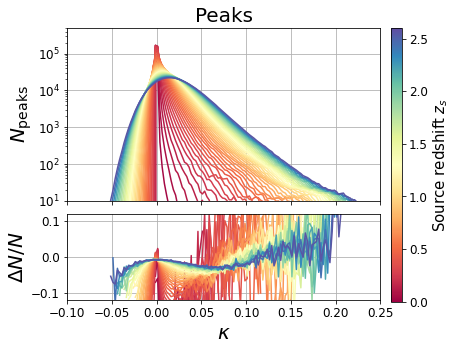

In [103]:
fig = plt.figure(figsize=(6,5))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)

kappa = d[0,:,0]

for i in range(40):
  iy, iystd, iydiff = d[i, :, 1], d[i, :, 2], d_diff[i, :, 1]
  # kappastd = sqrt( sum(column1^2*column2*0.1*)/sum(column2*0.1) )
  idx=np.where(iy>10)
  ax0.plot(kappa, iy, c=cmap(norm(zs[i])))
  ax1.plot(kappa[idx], iydiff[idx]/iy[idx], c=cmap(norm(zs[i])))



# ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(-0.1, 0.25)
ax0.set_ylim(10, 5e5)
ax0.set_xticklabels([])
ax0.grid()
# ax0.set_xlabel(r'$\kappa$', fontsize=20)
ax0.set_ylabel(r'$N_{\rm peaks}$', fontsize=20)


ax1.set_xlim(-0.1, 0.25)
ax1.set_ylim(-0.12, 0.12)
ax1.grid()
ax1.set_xlabel(r'$\kappa$', fontsize=20)
ax1.set_ylabel(r'$\Delta N/N$', fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.tight_layout()
ax0.set_title(r'Peaks', fontsize=20)
plt.savefig(root+"figures/Peaks_all.pdf", bbox_inches='tight')

plt.show()

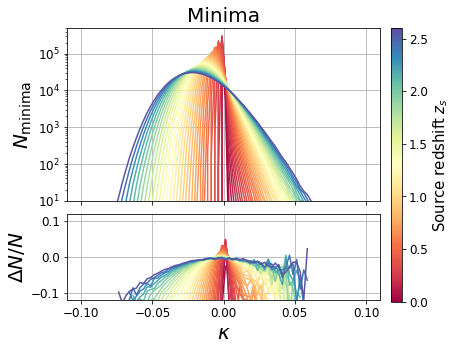

In [104]:
fig = plt.figure(figsize=(6,5))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)

kappa = d[0,:,0]

for i in range(40):
  iy, iystd, iydiff = d[i, :, 3], d[i, :, 4], d_diff[i, :, 3]
  # kappastd = sqrt( sum(column1^2*column2*0.1*)/sum(column2*0.1) )
  idx=np.where(iy>10)
  ax0.plot(kappa, iy, c=cmap(norm(zs[i])))
  ax1.plot(kappa[idx], iydiff[idx]/iy[idx], c=cmap(norm(zs[i])))



# ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(-0.11, 0.11)
ax0.set_ylim(10, 5e5)
ax0.set_xticklabels([])
ax0.grid()
# ax0.set_xlabel(r'$\kappa$', fontsize=20)
ax0.set_ylabel(r'$N_{\rm minima}$', fontsize=20)


ax1.set_xlim(-0.11, 0.11)
ax1.set_ylim(-0.12, 0.12)
ax1.grid()
ax1.set_xlabel(r'$\kappa$', fontsize=20)
ax1.set_ylabel(r'$\Delta N/N$', fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.tight_layout()
ax0.set_title(r'Minima', fontsize=20)
plt.savefig(root+"figures/Minima_all.pdf", bbox_inches='tight')
plt.show()